In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import json
from tools import create_x_y

In [3]:
def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y


def weight_data(x):
    # least represented class is 1.0, others are percentage_least/percentage_other
    percentages = {}
    len_x = len(x)
    for uniq_val in set(x):
        percentages[uniq_val] = sum([1 for i in x if i == uniq_val]) / len_x
    least = min(percentages, key=percentages.get)
    weights = {i: percentages[least] / percentages[i] for i in percentages}
    return weights


# match feature importances from vector with multiple lagged vals of each column
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }

    return imp

def save_importances_plot(fi, name, title, cols):
    import seaborn as sns
    importances = importances_from_lag(fi, cols) 
    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/{name}.pdf')

In [14]:
def measure(x, y):
    mode = "binary:logistic"

    clf = xgb.XGBClassifier(objective=mode, random_state=42, tree_method='gpu_hist', gpu_id=0)

    params  = {
    'n_estimators': [400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 10, 100]
    }

    time_split = TimeSeriesSplit(n_splits=5)
    xgb_search = GridSearchCV(
        clf,
        param_grid=params,
        cv=time_split,
        verbose=1,
    )
    split = int(0.8 * len(x))
    xgb_search.fit(x[:split], y[:split])
    y_pred = xgb_search.predict(x[split:])

    acc = accuracy_score(y[split:], y_pred)
    f1 = f1_score(y[split:], y_pred, average="weighted")
    roc = roc_auc_score(y[split:], y_pred)
    fi = xgb_search.best_estimator_.feature_importances_

    return round(acc, 3), round(f1, 3), round(roc, 3), fi

Starting amzn, 1.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting amzn, 2.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting amzn, 3.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting amzn, 6.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting amzn, 8.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting aapl, 1.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting aapl, 2.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting aapl, 3.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting aapl, 6.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting aapl, 8.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting msft, 1.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting msft, 2.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting msft, 3.
Fitting 5 folds for ea

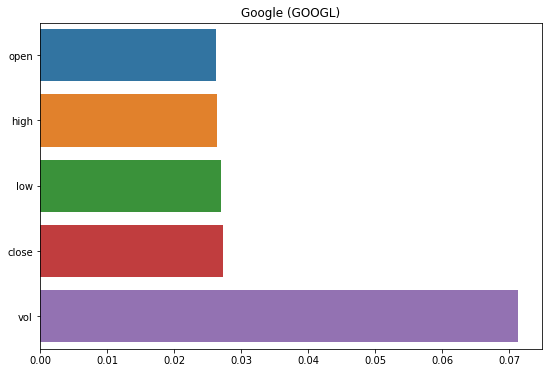

In [13]:
full_names = {
    "amzn": "Amazon",
    "aapl": "Apple",
    "msft": "Microsoft",
    "tsla": "Tesla",
    "goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
    }
weight = "baseline_2"

acc = {}
f1_metric = {}
roc = {}

path = f"../datasets/v3/binned/"

for company in full_names.keys():
    df = pd.read_csv(path + f"{company}.csv")
    OTHER_COLS = ["open", "high", "low", "close", "vol"]
    
    acc[company] = {}
    f1_metric[company] = {}
    roc[company] = {}
    fi = {}

    for lag in [1, 2, 3, 6, 8]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
        y = encode_y(y)
        print(f"Starting {company}, {lag}.")
        acc[company][lag], f1_metric[company][lag], roc[company][lag], fi[lag] = measure(
            x, y
        )
    save_importances_plot(
        fi[lag],
        f"v3/xgb_{company}_imp_BASE",
        f"{full_names[company]}",
        OTHER_COLS,
    )
with open(f"../results/v3/XGB_BASE.txt", "w") as file:
    to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric) + " ROC: " + json.dumps(roc)
    file.write(json.dumps(to_write))

Starting amzn, 1.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting amzn, 2.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting amzn, 3.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting amzn, 6.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting amzn, 8.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting aapl, 1.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting aapl, 2.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting aapl, 3.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting aapl, 6.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting aapl, 8.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting msft, 1.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting msft, 2.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Starting msft, 3.
Fitting 5 folds for ea

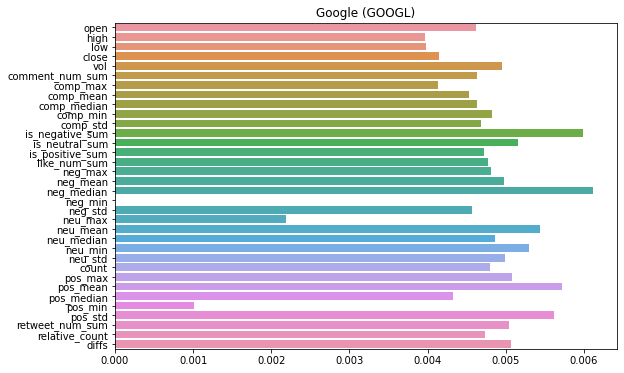

In [16]:
full_names = {
    "amzn": "Amazon",
    "aapl": "Apple",
    "msft": "Microsoft",
    "tsla": "Tesla",
    "goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
    }
weight = "no_w"

acc = {}
f1_metric = {}
roc = {}

path = f"../datasets/v3/binned/"

for company in full_names.keys():
    df = pd.read_csv(path + f"{company}.csv")
    VITAL_COLS = ["post_date", "ticker", "bin_2", "bin_3"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    
    acc[company] = {}
    f1_metric[company] = {}
    roc[company] = {}
    fi = {}

    for lag in [1, 2, 3, 6, 8]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
        y = encode_y(y)
        print(f"Starting {company}, {lag}.")
        acc[company][lag], f1_metric[company][lag], roc[company][lag], fi[lag] = measure(
            x, y
        )
    save_importances_plot(
        fi[lag],
        f"v3/xgb_{company}_imp_no_W",
        f"{full_names[company]}",
        OTHER_COLS,
    )
with open(f"../results/v3/XGB_no_w.txt", "w") as file:
    to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric) + " ROC: " + json.dumps(roc)
    file.write(json.dumps(to_write))

In [27]:
acc

{'tsla': {3: 0.3563615428900403,
  6: 0.3747841105354059,
  10: 0.35368663594470046,
  16: 0.3723342939481268}}

In [21]:
acc_good = {f"{company}_{lag}": round(acc[company][lag], 4) for lag in acc[company] for company in acc}
f1_good = {f"{company}_{lag}": round(f1_metric[company][lag], 4) for lag in acc[company] for company in acc}

In [23]:
f1_good

{'amzn_3': 0.491, 'amzn_6': 0.498, 'amzn_10': 0.4935, 'amzn_16': 0.4916}

Text(0.5, 1.0, 'F1')

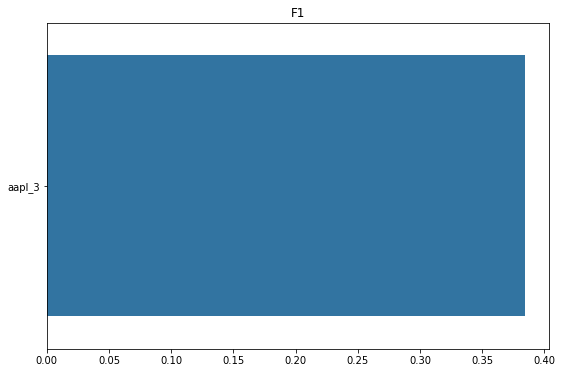

In [11]:
import seaborn as sns

figure = plt.gcf()
figure.set_size_inches(9, 6)
sns.barplot(x=list(f1_good.values()), y=list(f1_good.keys())).set_title("F1")
